In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mmd import MMD_3_Sample_Test

seed=42
np.random.seed(seed)

# Data preparation

In [38]:
def generate_data_from_gaussians(mu_1, mu_2, sigma=1., gamma=0.5, n=250):
    """Generates data from three gaussians, one with interpolated mean from the other two."""
    y = np.random.multivariate_normal(mu_1, np.eye(2), n)
    z = np.random.multivariate_normal(mu_2, np.eye(2), n)
    x = np.random.multivariate_normal((1-gamma)*mu_1 + gamma*mu_2, sigma*np.eye(2), n)

    return x, y, z

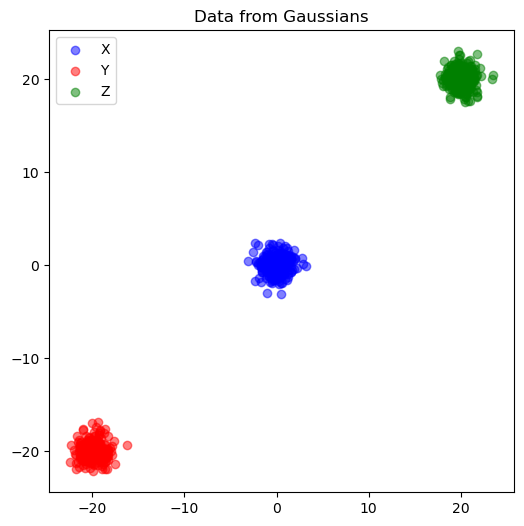

In [39]:
def plot_data(x, y, z, title):
    """Plots the data."""
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], color='blue', alpha=0.5, label='X')
    plt.scatter(y[:, 0], y[:, 1], color='red', alpha=0.5, label='Y')
    plt.scatter(z[:, 0], z[:, 1], color='green', alpha=0.5, label='Z')
    plt.legend()
    plt.title(title)
    plt.show()


X, Y, Z = generate_data_from_gaussians(np.array([-20, -20]), np.array([20, 20]))
plot_data(X, Y, Z, title='Data from Gaussians')

# Experiment with MMD test

Note on MMD-test:

MMD - Maximum Mean Disrepancy - distance between two means of distrubtions in some space $F$ (for which we can use kernel trick to compute inner-product <=> distances)

MMD-test: 
- $H_0$: $~~MMD(F, Px, Py) ≤ MMD(F, Px, Pz)$
- $H_1$: $~~MMD(F, Px, Py) > MMD(F, Px, Pz)$

In other words, $H_0$ is "$Y$ is closer to $X$ then $Z$"

Figure 3 from paper:

In [40]:
mean1 = np.array([-5, -5])
mean2 = np.array([5, 5])
sigma=12.

pvals = []
for gamma in np.arange(0.1, 0.9, 5e-3):
    X, Y, Z = generate_data_from_gaussians(mean1, mean2, sigma, gamma=gamma)
    
    mmd = MMD_3_Sample_Test(X, Y, Z)

    pvalue, _, _, _, _ = mmd 
    pvals.append(pvalue)

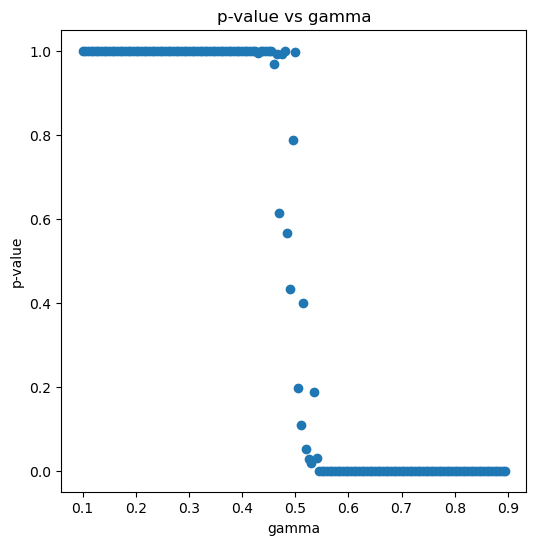

In [41]:
# plot p-values
plt.figure(figsize=(6, 6))
plt.scatter(np.arange(0.1, 0.9, 5e-3), pvals)
plt.xlabel('gamma')
plt.ylabel('p-value')
plt.title('p-value vs gamma')
plt.show()